In [ ]:
# !pip install qiskit==1.4.4 qiskit-machine-learning==0.8.4 pylatexenc

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## **Classification and Regression**
---

### **Classification**

---

#### **Steps to classify using Estimator QNN**

---

 - **Step 1**: create dataset

 - **Step 2**: convert labels to {0,1}

 - **Step 3**: build a feature map

 - **Step 4**: build a variational ansatz

 - **Step 5**: combine them into a QNN

 - **Step 6**: wrap QNN into a classifier

 - **Step 7**: train the model

 - **Step 8**: test accuracy.

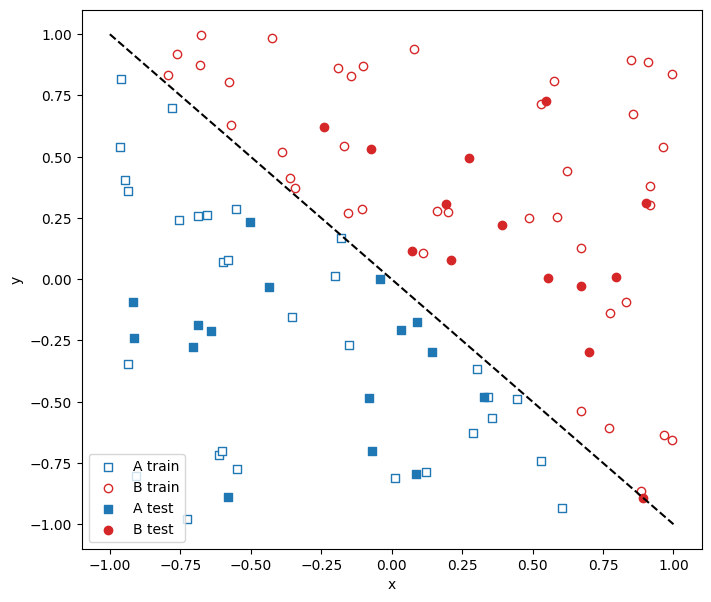

In [ ]:
# -----------------------------------------------------
# STEP 1 & 2. create dataset & convert labels
# -----------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

num_features = 2
num_samples = 100


X = 2 * np.random.rand(num_samples, num_features) - 1
Y = (X[:, 0] + X[:, 1] >= 0).astype(int)
# Y = 2 * Y - 1

# One-hot encode labels: 0 -> [1, 0], 1 -> [0, 1]
Y_onehot = np.zeros((num_samples, 2))
Y_onehot[np.arange(num_samples), Y] = 1

# split the dataset
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42
)


# visualize data
plt.figure(figsize=(8, 7))
plt.scatter(
    X_train[np.where(Y_train[:] == 0), 0],
    X_train[np.where(Y_train[:] == 0), 1],
    marker='s', facecolors='w', edgecolors='C0', label="A train"
)
plt.scatter(
    X_train[np.where(Y_train[:] == 1), 0],
    X_train[np.where(Y_train[:] == 1), 1],
    marker='o', facecolors='w', edgecolors='C3', label="B train"
)
plt.scatter(
    X_test[np.where(Y_test[:] == 0), 0],
    X_test[np.where(Y_test[:] == 0), 1],
    marker='s', facecolors='C0', label="A test"
)
plt.scatter(
    X_test[np.where(Y_test[:] == 1), 0],
    X_test[np.where(Y_test[:] == 1), 1],
    marker='o', facecolors='C3', label="B test"
)
plt.plot([-1, 1], [1, -1], 'k--')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


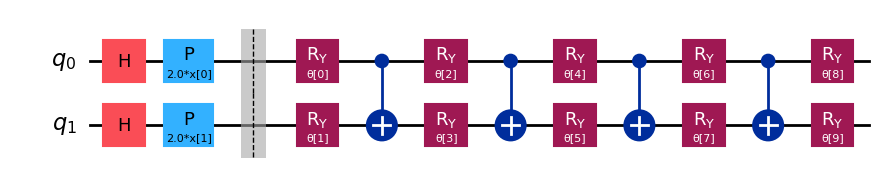

In [ ]:
# -----------------------------------------------------
# STEP 3 & 4. build feature map & variational circuit
# -----------------------------------------------------
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap


# feature map
# fm = ZZFeatureMap(feature_dimension=num_features, reps=1)
fm = ZFeatureMap(feature_dimension=num_features, reps=1)

# variational ansatz
ansatz = RealAmplitudes(num_qubits=num_features, reps=4)

# params
x = fm.parameters
w = ansatz.parameters



# build combined circuit
qc = QuantumCircuit(num_features)
qc.compose(fm, inplace=True)
qc.barrier()
qc.compose(ansatz, inplace=True)

qc.decompose().draw("mpl")


In [ ]:
# -----------------------------------------------------
# STEP 5. combine into QNN
# -----------------------------------------------------
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN

estimator = Estimator()

# observables
# observable = SparsePauliOp.from_list([("Z" + "I" * (num_features-1), 1)])
observable = SparsePauliOp.from_list([("I" * num_features, 0.5), ("Z" + "I" * (num_features-1), -0.5)])

# define estimator QNN
est_qnn = EstimatorQNN(
    circuit=qc,
    estimator=estimator,
    observables=observable,
    input_params=x,
    weight_params=w
)

print(est_qnn.num_inputs)
print(est_qnn.num_weights)



2
10


In [ ]:
est_qnn.forward(X[0,:], np.random.random(est_qnn.num_weights))

array([[0.51934748]])

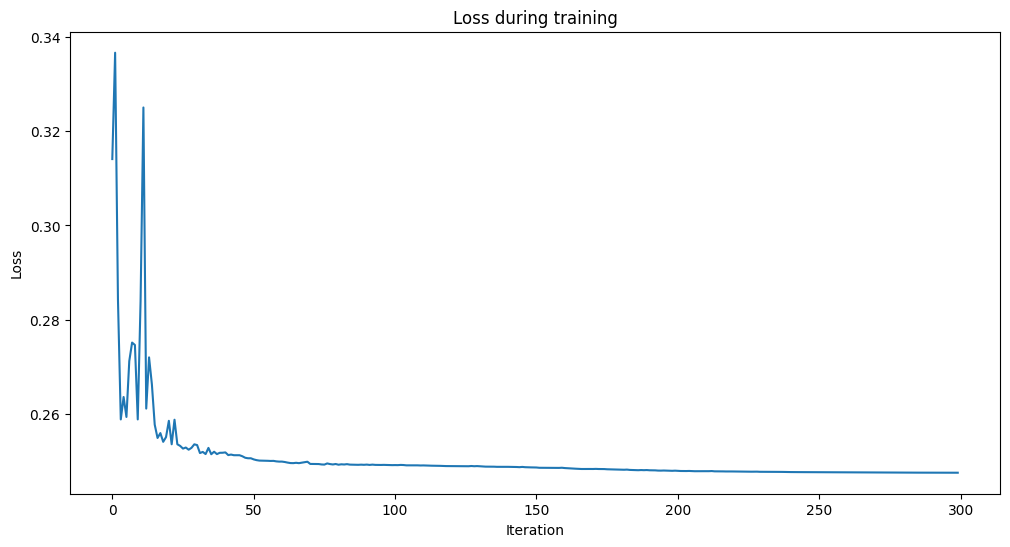

In [ ]:
# -----------------------------------------------------
# STEP 6 & 7. wrap into NNClassifier and train the model
# -----------------------------------------------------
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.optimizers import COBYLA
from IPython.display import clear_output


# define callback function
obj_vals = []
def callback_func(weights, value):
    obj_vals.append(value)

    clear_output(wait=True)

    plt.plot(obj_vals)
    plt.title("Loss during training")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()


# define nn classifier
estimator_clf = NeuralNetworkClassifier(
    neural_network=est_qnn,
    optimizer=COBYLA(maxiter=300),
    callback=callback_func
)

# -----------------------------------------------------
# STEP 6. Train classifier
# -----------------------------------------------------
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_clf.fit(X_train, Y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)


In [ ]:
# -----------------------------------------------------
# STEP 7. Train accuracy
# -----------------------------------------------------
train_acc = estimator_clf.score(X_train, Y_train)
print("Training Accuracy:", train_acc)


# -----------------------------------------------------
# STEP 8. Test accuracy
# -----------------------------------------------------
test_acc = estimator_clf.score(X_test, Y_test)
print("Test Accuracy:", test_acc)

Training Accuracy: 0.5714285714285714
Test Accuracy: 0.4666666666666667


In [ ]:
estimator_clf.weights

array([-0.22765824,  1.49373503,  1.63433732,  0.29642215, -0.01325014,
        1.36338046,  0.21293333,  0.95723905,  0.7732346 ,  0.4215351 ])

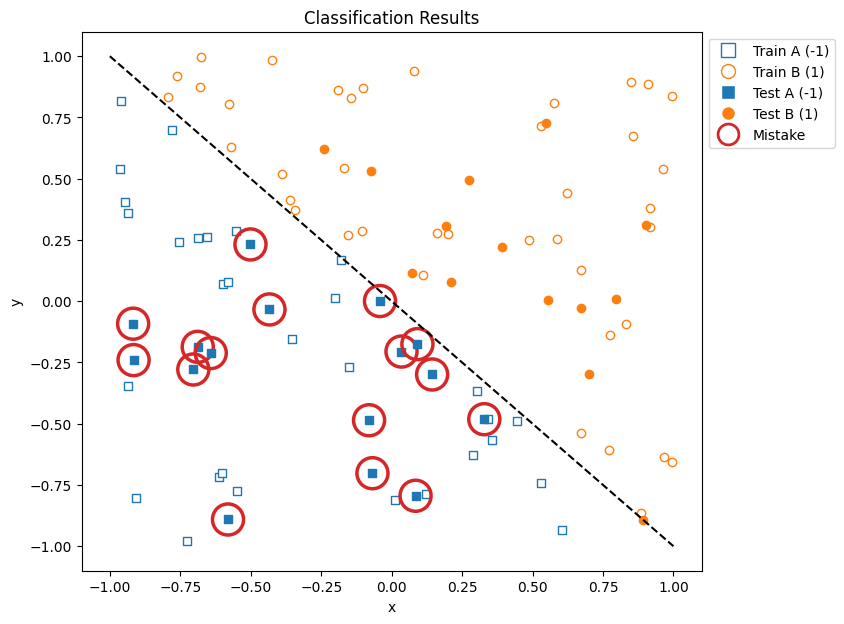

In [ ]:
from matplotlib.lines import Line2D
Y_pred = estimator_clf.predict(X_test).flatten()

plt.figure(figsize=(8, 7))

# plot Training Data
for feature, label in zip(X_train, Y_train):
    COLOR = 'C0' if label == 0 else 'C1'
    MARKER = 's' if label == 0 else 'o'
    plt.scatter(feature[0], feature[1], marker=MARKER, facecolors='w', edgecolors=COLOR)

# plot Test Data
for feature, label, pred in zip(X_test, Y_test, Y_pred):
    COLOR = 'C0' if label == 0 else 'C1'
    MARKER = 's' if label == 0 else 'o'
    plt.scatter(feature[0], feature[1], marker=MARKER, facecolors=COLOR)

    # Mark wrongly classified
    if label != pred:
        plt.scatter(feature[0], feature[1], marker='o', s=500, linewidths=2.5, facecolor='none', edgecolor='C3')
# legend element
legend_elements = [
    Line2D([0], [0], marker='s', color='w', markeredgecolor='C0', markerfacecolor='w', label='Train A (-1)', ms=10),
    Line2D([0], [0], marker='o', color='w', markeredgecolor='C1', markerfacecolor='w', label='Train B (1)', ms=10),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='C0', markeredgecolor=None, label='Test A (-1)', ms=10),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='C1', markeredgecolor=None, label='Test B (1)', ms=10),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='none', markeredgecolor='C3', label='Mistake', mew=2, ms=15)
]

plt.plot([-1, 1], [1, -1], 'k--')
plt.title('Classification Results')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

#### **Using Sampler QNN**

---

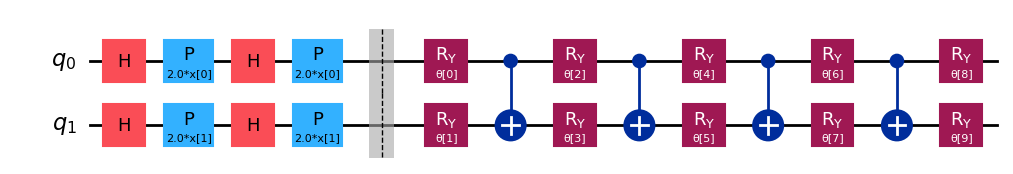

In [ ]:
# -----------------------------------------------------
# STEP 3 & 4. build feature map & variational circuit
# -----------------------------------------------------
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap


# feature map
# fm = ZZFeatureMap(feature_dimension=num_features, reps=1)
fm = ZFeatureMap(feature_dimension=num_features, reps=2)

# variational ansatz
ansatz = RealAmplitudes(num_qubits=num_features, reps=4)

# params
x = fm.parameters
w = ansatz.parameters



# build combined circuit
qc = QuantumCircuit(num_features)
qc.compose(fm, inplace=True)
qc.barrier()
qc.compose(ansatz, inplace=True)

qc.decompose().draw("mpl")


In [ ]:
# -----------------------------------------------------
# STEP 5. combine into QNN
# -----------------------------------------------------
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Sampler
from qiskit_machine_learning.neural_networks import SamplerQNN

sampler = Sampler()

# interpret function
def parity(x):
    return "{:b}".format(x).count("1") % 2

# define estimator QNN
sampler_qnn = SamplerQNN(
    circuit=qc,
    input_params=x,
    weight_params=w,
    sampler=sampler,
    output_shape=2,
    interpret=parity
)

print(sampler_qnn.num_inputs)
print(sampler_qnn.num_weights)



2
10


In [ ]:
# -----------------------------------------------------
# STEP 6 & 7. wrap into NNClassifier and train the model
# -----------------------------------------------------
# define callback function
obj_vals = []
def callback_func(weights, value):
    obj_vals.append(value)

    clear_output(wait=True)

    plt.plot(obj_vals)
    plt.title("Loss during training")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()


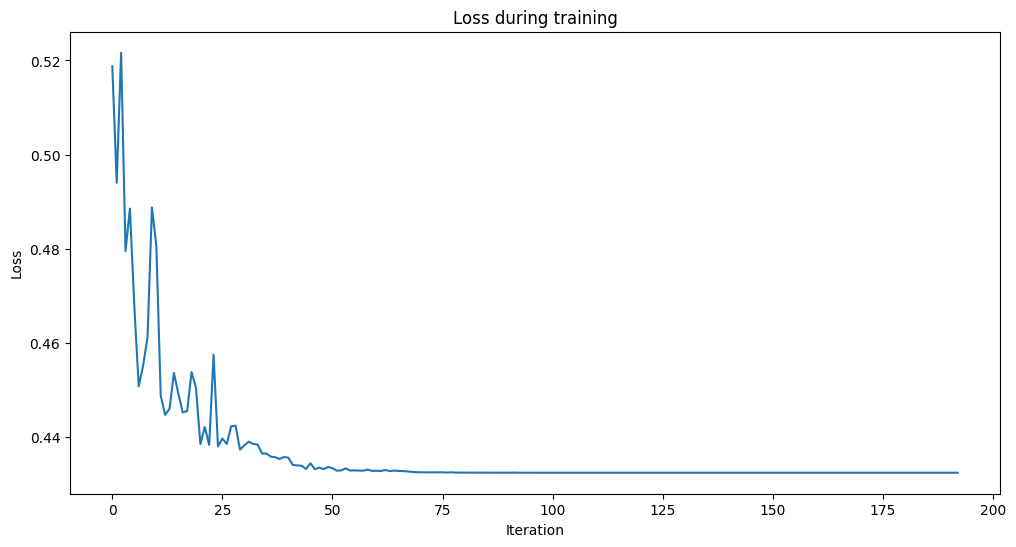


Train Accuracy: 0.56

Final Test Accuracy: 0.40


In [ ]:
# 6. TRAIN CLASSIFIER

sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn,
    optimizer=COBYLA(maxiter=200),
    callback=callback_func
)



print("Starting training...")
plt.rcParams["figure.figsize"] = (12, 6)
sampler_classifier.fit(X_train, Y_train)
plt.rcParams["figure.figsize"] = (6, 4)



# 6. CHECK ACCURACY
train_acc = sampler_classifier.score(X_train, Y_train)
print(f"\nTrain Accuracy: {train_acc:.2f}")
score = sampler_classifier.score(X_test, Y_test)
print(f"\nFinal Test Accuracy: {score:.2f}")

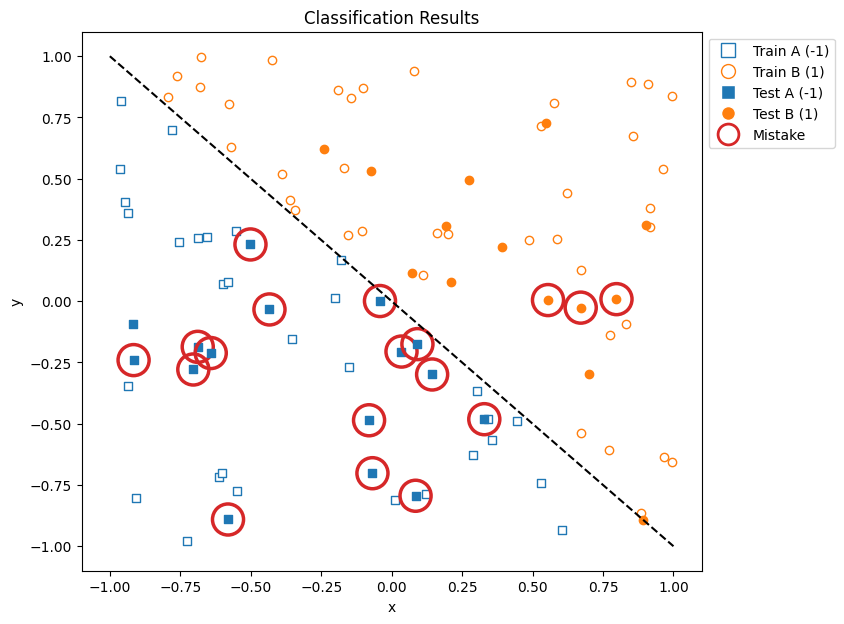

In [ ]:
from matplotlib.lines import Line2D
Y_pred = sampler_classifier.predict(X_test).flatten()

plt.figure(figsize=(8, 7))

# plot Training Data
for feature, label in zip(X_train, Y_train):
    COLOR = 'C0' if label == 0 else 'C1'
    MARKER = 's' if label == 0 else 'o'
    plt.scatter(feature[0], feature[1], marker=MARKER, facecolors='w', edgecolors=COLOR)

# plot Test Data
for feature, label, pred in zip(X_test, Y_test, Y_pred):
    COLOR = 'C0' if label == 0 else 'C1'
    MARKER = 's' if label == 0 else 'o'
    plt.scatter(feature[0], feature[1], marker=MARKER, facecolors=COLOR)

    # Mark wrongly classified
    if label != pred:
        plt.scatter(feature[0], feature[1], marker='o', s=500, linewidths=2.5, facecolor='none', edgecolor='C3')
# legend element
legend_elements = [
    Line2D([0], [0], marker='s', color='w', markeredgecolor='C0', markerfacecolor='w', label='Train A (-1)', ms=10),
    Line2D([0], [0], marker='o', color='w', markeredgecolor='C1', markerfacecolor='w', label='Train B (1)', ms=10),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='C0', markeredgecolor=None, label='Test A (-1)', ms=10),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='C1', markeredgecolor=None, label='Test B (1)', ms=10),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='none', markeredgecolor='C3', label='Mistake', mew=2, ms=15)
]

plt.plot([-1, 1], [1, -1], 'k--')
plt.title('Classification Results')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

#### **Using VQC**

---

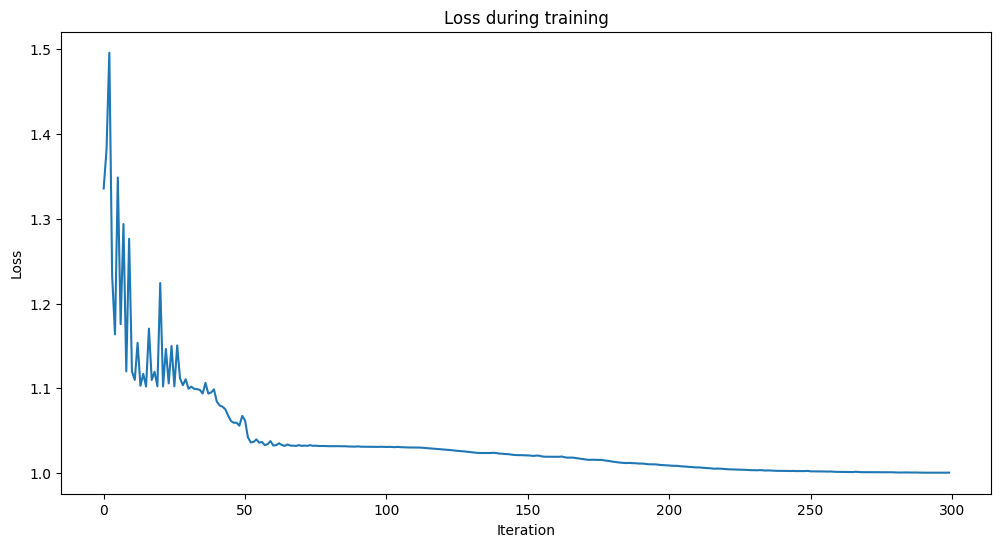

0.47

In [ ]:
from qiskit_machine_learning.algorithms import VQC

vqc = VQC(
    feature_map=fm,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(maxiter=300),
    callback=callback_func,
    sampler=sampler
)

obj_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X, Y_onehot)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X, Y_onehot)

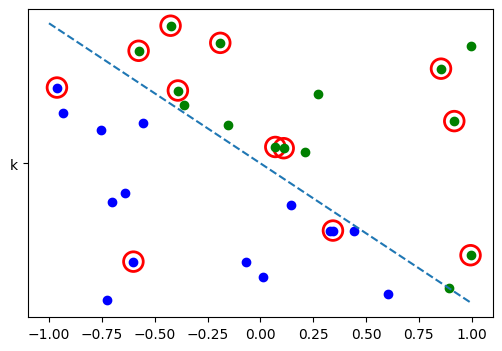

In [ ]:
y_predict = vqc.predict(X_test)
for x, y_target, y_p in zip(X, Y_onehot, y_predict):
    if y_target[0] == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", 'k')
plt.show()

### **Regression**

---

#### **Using estimator QNN**

---

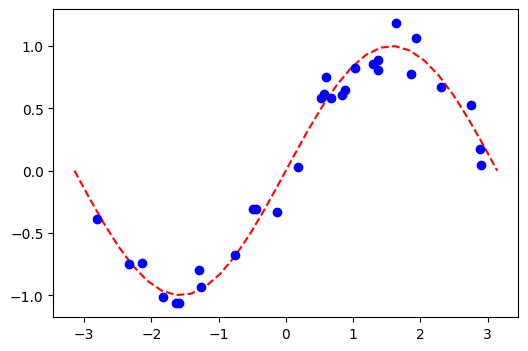

In [ ]:
num_samples = 30
ep = 0.2

lb, ub = -np.pi, np.pi

X_ = np.linspace(lb, ub, num=num_samples).reshape(30, 1)
f = lambda x : np.sin(x)

X = (ub - lb) * np.random.random([num_samples, 1]) + lb
y = f(X[:, 0]) + ep * (2 * np.random.random(num_samples) - 1)

plt.plot(X_, f(X_), "r--")
plt.plot(X, y, "bo")
plt.show()

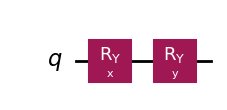

In [ ]:
from qiskit.circuit import Parameter

# construct simple feature map  =>  R_y gate
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

# construct simple ansatz   =>   R_y gate
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

# construct a circuit
qc = QuantumCircuit(1)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
qc.draw('mpl')


In [ ]:
print(qc.num_parameters)

2


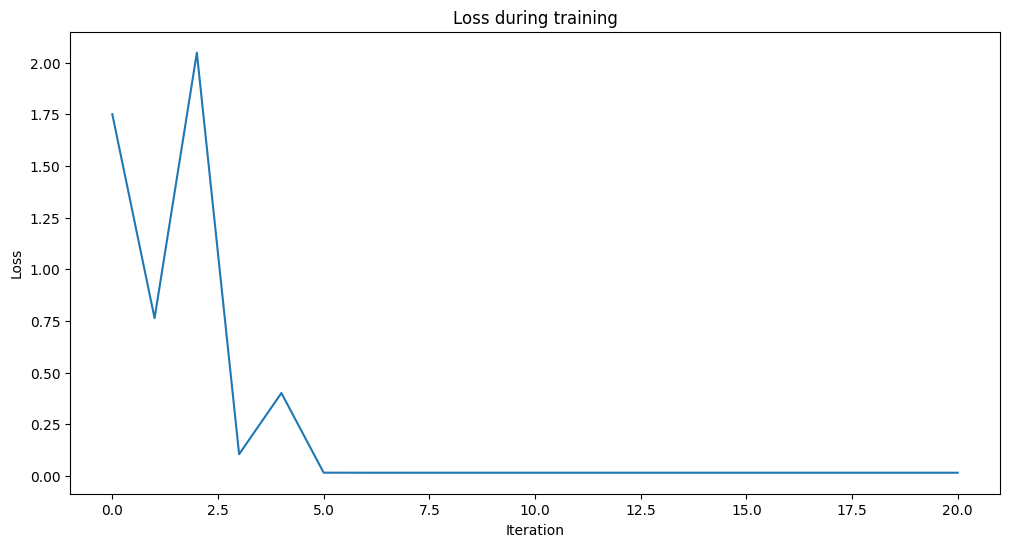

[-1.55770484]


In [ ]:
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor
from qiskit_machine_learning.optimizers import L_BFGS_B

estimator = Estimator()

# instantiate estimatorQNN
regression_estimator_qnn = EstimatorQNN(
    circuit=qc,
    estimator=estimator,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

regressor = NeuralNetworkRegressor(
    neural_network=regression_estimator_qnn,
    loss="squared_error",
    optimizer=L_BFGS_B(maxiter=5),
    callback=callback_func,
)


# Training
obj_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
regressor.fit(X, y)
plt.rcParams["figure.figsize"] = (6, 4)

# score the result
regressor.score(X, y)
print(regressor.weights)

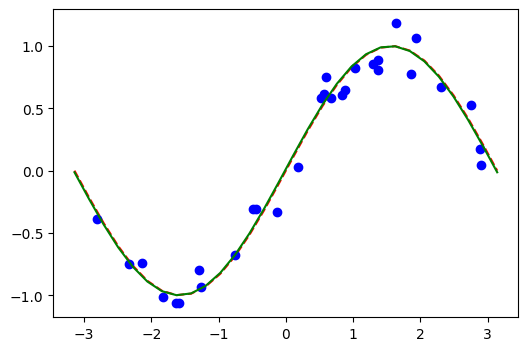

In [ ]:
# predict the output
y_ = regressor.predict(X_)

# plotting
plt.plot(X_, f(X_), "r--")
plt.plot(X, y, "bo")
plt.plot(X_, y_, "g-")
plt.show()

#### **Using VQR**

---

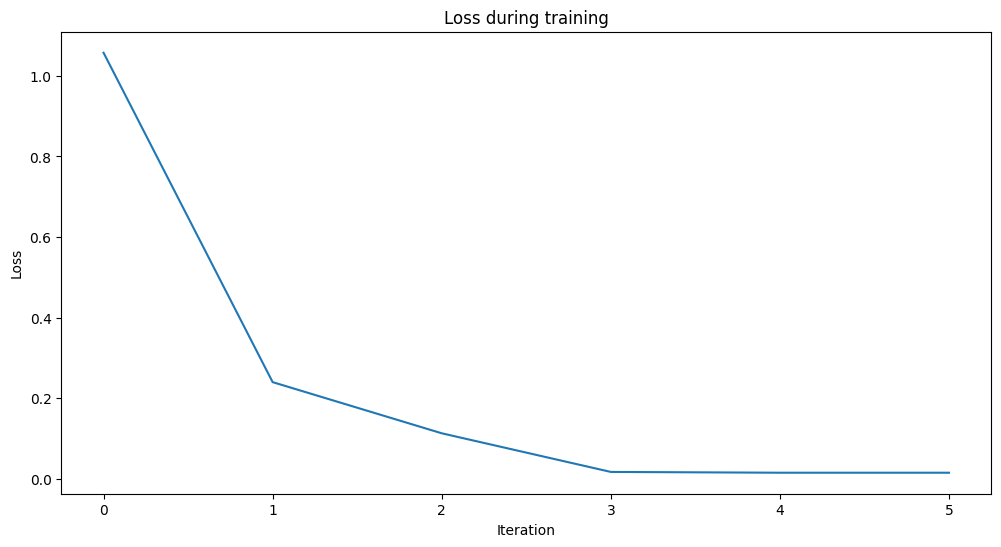

0.9710683674908237
[-1.55778383]


In [ ]:
from qiskit_machine_learning.algorithms.regressors import  VQR

vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=L_BFGS_B(maxiter=5),
    callback=callback_func,
    estimator=estimator
)

obj_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
vqr.fit(X, y)
plt.rcParams["figure.figsize"] = (6, 4)

# score result
print(vqr.score(X, y))
print(vqr.weights)

Mean absolute error: 0.008445
Mean absolute error: 0.008497


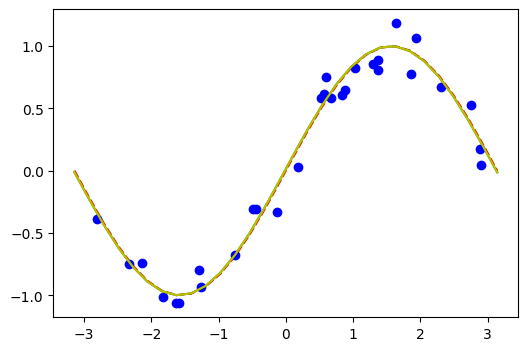

In [ ]:
# predict y
y_ = vqr.predict(X_)
y_r = regressor.predict(X_)

error = np.mean(np.abs(y_ - f(X_)))
print("Mean absolute error: %f" % error)

error_regressor = np.mean(np.abs(y_r - f(X_)))
print("Mean absolute error: %f" % error_regressor)



# plotting
plt.plot(X_, f(X_), "r--")
plt.plot(X, y, "bo")
plt.plot(X_, y_, "g-")
plt.plot(X_, y_r, "y-")
plt.show()